# 🛍️ FLO Customer Segmentation (Unsupervised Learning)

This project applies **K-Means** and **Hierarchical Clustering** to segment FLO’s omnichannel customers based on purchasing behavior. Numeric features were standardized, optimal cluster count was determined via **Elbow** and **Dendrogram**, and customers were grouped into actionable segments.

**Goal:** identify behavior-based customer groups to support targeted marketing, retention planning, and loyalty strategy.

### 🔍 Steps
- Data cleaning & feature engineering (Recency, Tenure)
- Standardization with `StandardScaler`
- Optimal cluster selection (Elbow + Dendrogram)
- Clustering with K-Means & Agglomerative Clustering
- Segment profiling (purchase frequency, value, recency)

### 📌 Key Segments
| Segment | Description |
|---------|-------------|
| 0 | Low-value, rare shoppers (win-back focus) |
| 1 | High-value VIP (loyalty & exclusives) |
| 2 | New / potential (onboarding & activation) |
| 3 | Mid-value stable (upsell & basket growth) |

### 🎯 Result
Clear behavioral clusters were identified, enabling personalized campaigns, improved retention actions, and more efficient marketing spend.



# 🔧 1. Import Required Libraries

In [129]:
!pip install pydotplus missingno astor skompiler yellowbrick joblib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder,RobustScaler
import scipy.stats as stats
import missingno as msno
import joblib 
import pydotplus
from skompiler import skompile
import datetime as dt

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering


from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 📥 2. Loading the Dataset

In [130]:
df = pd.read_csv("/kaggle/input/flo-data-20k/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


# 🔍 3. Exploratory Data Analysis (EDA)

In [131]:
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08   
2  69b

In [132]:
date_columns = ["first_order_date","last_order_date","last_order_date_online","last_order_date_offline"]
for col in date_columns:
     df[col] = pd.to_datetime(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

# 📌 4. Selecting Variables for Customer Segmentation

In [133]:
today_date = df["last_order_date"].max() + pd.Timedelta(days=2)

df["customer_total_order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["recency"] = (today_date - df["last_order_date"]).dt.days
df["tenure"] = (today_date - df["first_order_date"]).dt.days
df["avg_order_value"] = df["customer_value_total"] / df["customer_total_order"]

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,customer_total_order,customer_value_total,recency,tenure,avg_order_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370,95,214,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550,105,1574,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320,186,552,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970,135,146,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980,86,668,104.990


# 🔢 5. Classifying Variables: Numerical vs Categorical

In [134]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Grab column names based on their types and cardinality.

    Parameters:
    cat_th (int): Threshold for numerical columns to be considered categorical. Default is 10.
    car_th (int): Threshold for categorical columns to be considered cardinal. Default is 20.

    Returns:
    tuple: Lists of categorical columns, numerical columns, and cardinal columns.
    """
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ['category', 'object', 'bool']]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ['int', 'float']]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ['category', 'object']]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['int', 'float', 'int64', 'float64']]
    num_cols = [col for col in num_cols if col not in cat_cols]
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'datetime64[ns]']
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'date_cols: {len(date_cols)}')

    return cat_cols, num_cols, cat_but_car, date_cols

cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)

Observations: 19945
Variables: 17
cat_cols: 2
num_cols: 9
cat_but_car: 2
num_but_cat: 0
date_cols: 4


In [135]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online',
 'customer_total_order',
 'customer_value_total',
 'recency',
 'tenure',
 'avg_order_value']

# 🚨 6. Outlier Detection  

In [136]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, plot=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    if outliers.any(axis=None):
        if plot:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=dataframe[col_name])
            plt.title(f'Outliers in {col_name}')
            plt.show()
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [137]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

order_num_total_ever_online True
order_num_total_ever_offline True
customer_value_total_ever_offline True
customer_value_total_ever_online True
customer_total_order True
customer_value_total True
recency False
tenure False
avg_order_value True


In [138]:
model_df = df[num_cols]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,customer_total_order,customer_value_total,recency,tenure,avg_order_value
0,4.000,1.000,139.990,799.380,5.000,939.370,95,214,187.874
1,19.000,2.000,159.970,1853.580,21.000,2013.550,105,1574,95.883
2,3.000,2.000,189.970,395.350,5.000,585.320,186,552,117.064
3,1.000,1.000,39.990,81.980,2.000,121.970,135,146,60.985
4,1.000,1.000,49.990,159.990,2.000,209.980,86,668,104.990


count   19945.000
mean        3.044
std         3.426
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         2.000
60%         2.000
70%         3.000
80%         4.000
90%         7.000
95%        10.000
99%        20.000
max        23.500
Name: order_num_total_ever_online, dtype: float64


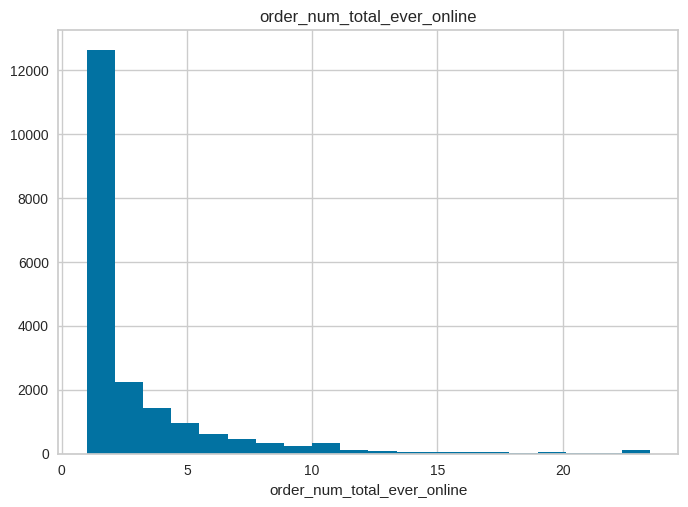

count   19945.000
mean        1.868
std         1.315
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         1.000
60%         2.000
70%         2.000
80%         3.000
90%         4.000
95%         4.000
99%         7.000
max         8.500
Name: order_num_total_ever_offline, dtype: float64


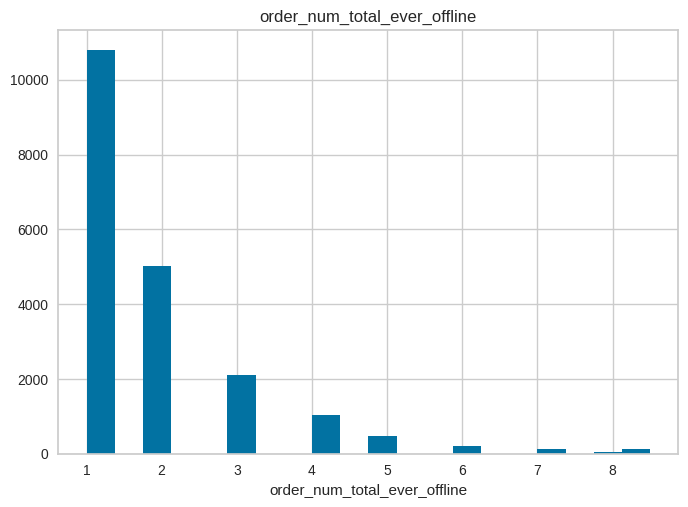

count   19945.000
mean      249.738
std       233.356
min        10.000
5%         39.990
10%        59.990
20%        89.980
30%       110.480
40%       140.230
50%       179.980
60%       220.860
70%       281.868
80%       365.058
90%       519.950
95%       694.222
99%      1219.947
max      1675.570
Name: customer_value_total_ever_offline, dtype: float64


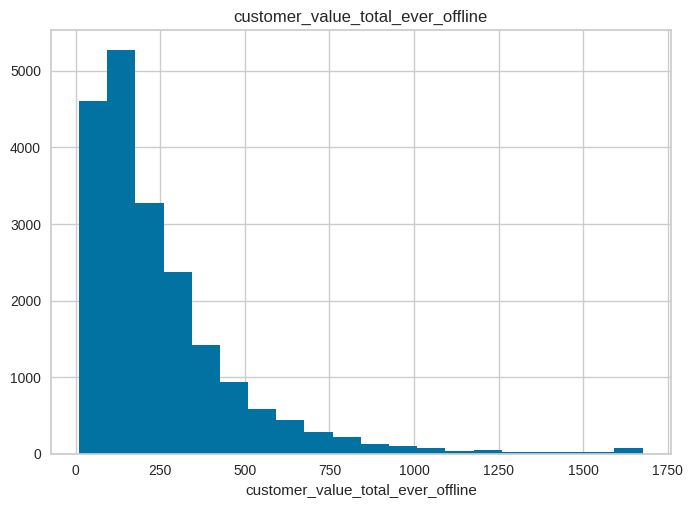

count   19945.000
mean      481.268
std       568.278
min        12.990
5%         63.990
10%        84.990
20%       125.990
30%       173.970
40%       219.990
50%       286.460
60%       371.944
70%       491.526
80%       690.868
90%      1082.036
95%      1556.726
99%      3143.810
max      3795.830
Name: customer_value_total_ever_online, dtype: float64


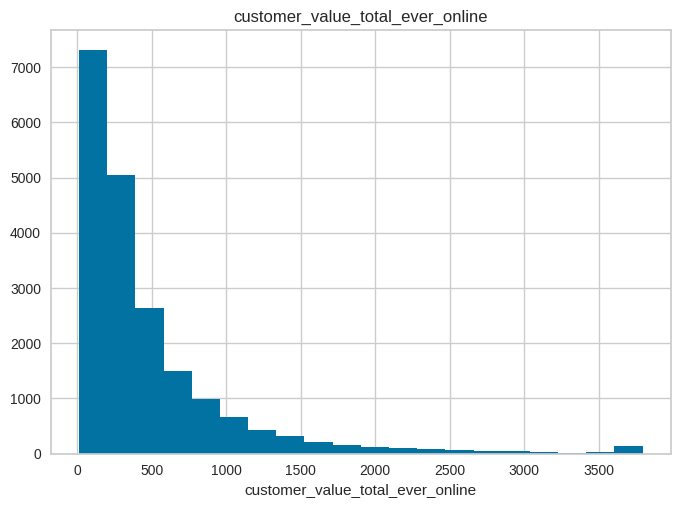

count   19945.000
mean        4.942
std         3.820
min         2.000
5%          2.000
10%         2.000
20%         2.000
30%         3.000
40%         3.000
50%         4.000
60%         4.000
70%         5.000
80%         7.000
90%         9.000
95%        12.000
99%        22.000
max        27.000
Name: customer_total_order, dtype: float64


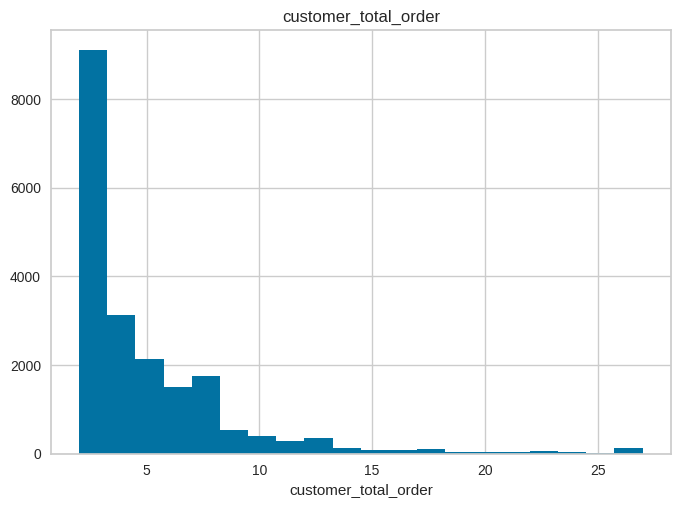

count   19945.000
mean      735.696
std       641.516
min        44.980
5%        175.480
10%       224.970
20%       302.188
30%       378.888
40%       455.826
50%       545.270
60%       660.380
70%       803.706
80%      1020.036
90%      1429.938
95%      1921.924
99%      3606.356
max      4541.590
Name: customer_value_total, dtype: float64


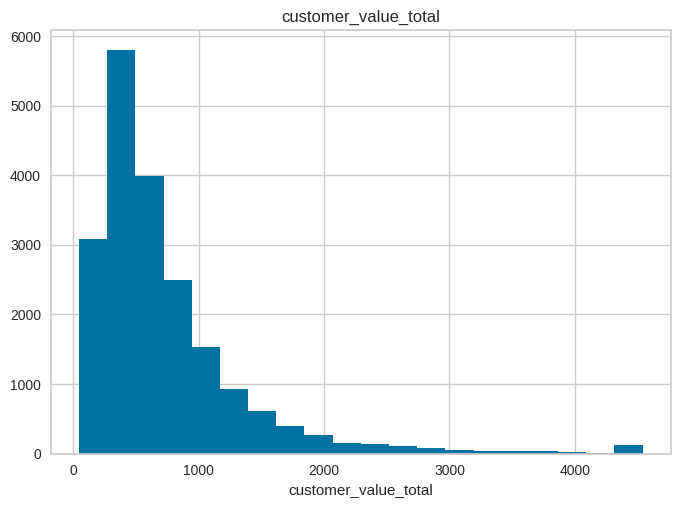

count   19945.000
mean      134.458
std       103.281
min         2.000
5%          9.000
10%        16.000
20%        33.000
30%        56.000
40%        83.000
50%       111.000
60%       145.000
70%       186.000
80%       232.000
90%       308.000
95%       335.000
99%       360.000
max       367.000
Name: recency, dtype: float64


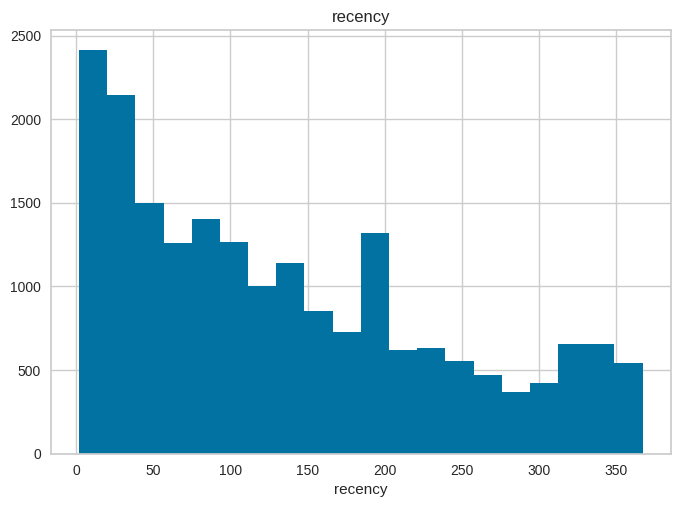

count   19945.000
mean      801.303
std       523.397
min         5.000
5%        209.200
10%       338.000
20%       478.000
30%       549.000
40%       600.000
50%       651.000
60%       730.000
70%       814.000
80%       967.200
90%      1544.000
95%      2074.000
99%      2605.000
max      3060.000
Name: tenure, dtype: float64


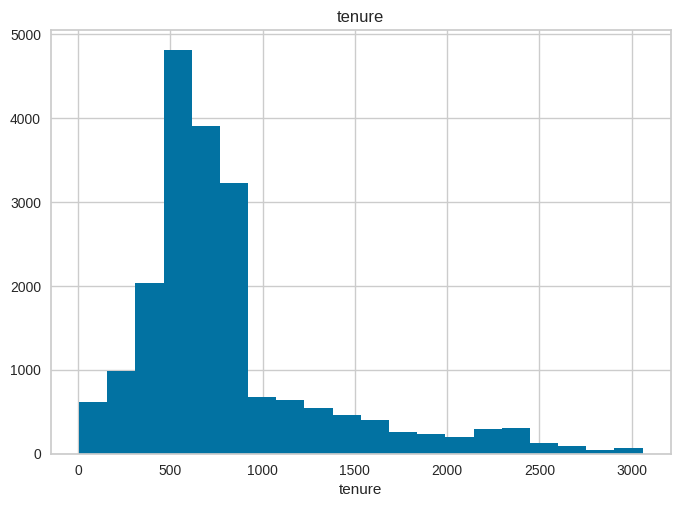

count   19945.000
mean      151.877
std        71.783
min        22.490
5%         68.471
10%        80.088
20%        96.850
30%       110.150
40%       123.302
50%       136.735
60%       152.562
70%       170.620
80%       196.092
90%       238.954
95%       285.639
99%       404.761
max       611.393
Name: avg_order_value, dtype: float64


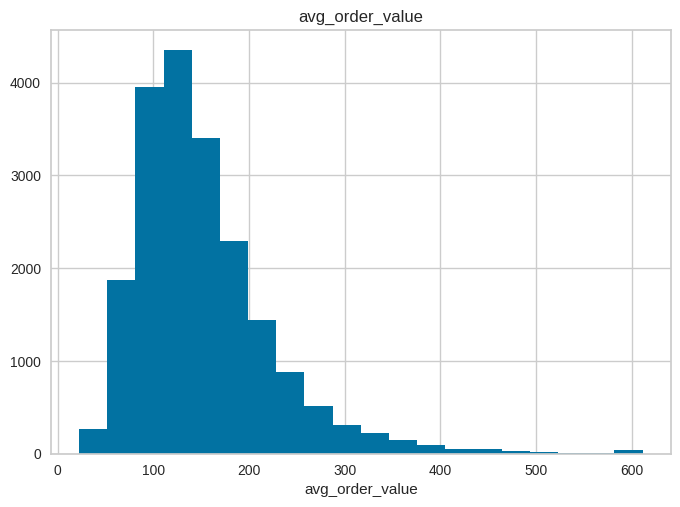

In [139]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in model_df:
    num_summary(model_df , col , True)

In [140]:

for col in model_df:
    model_df[col] = np.cbrt(model_df[col])

    


count   19945.000
mean        1.328
std         0.393
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         1.260
60%         1.260
70%         1.442
80%         1.587
90%         1.913
95%         2.154
99%         2.714
max         2.864
Name: order_num_total_ever_online, dtype: float64


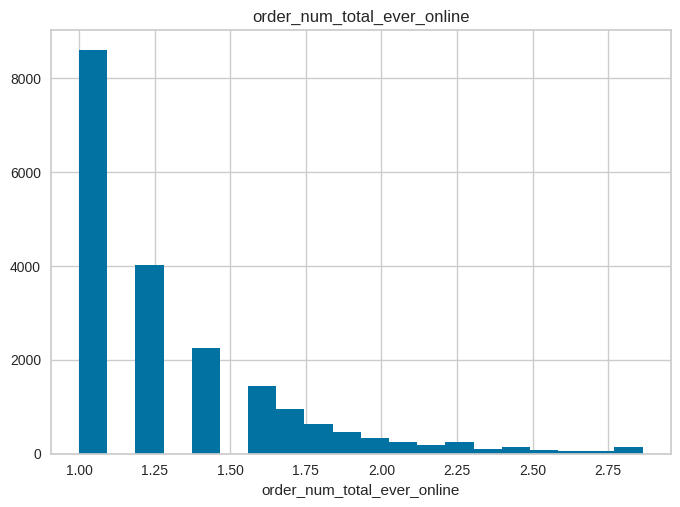

count   19945.000
mean        1.183
std         0.236
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         1.000
60%         1.260
70%         1.260
80%         1.442
90%         1.587
95%         1.587
99%         1.913
max         2.041
Name: order_num_total_ever_offline, dtype: float64


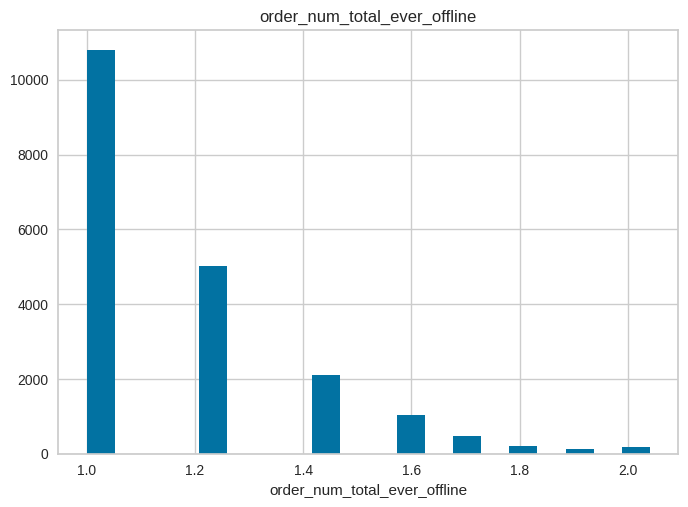

count   19945.000
mean        5.832
std         1.661
min         2.154
5%          3.420
10%         3.915
20%         4.481
30%         4.798
40%         5.195
50%         5.646
60%         6.045
70%         6.557
80%         7.147
90%         8.041
95%         8.855
99%        10.685
max        11.877
Name: customer_value_total_ever_offline, dtype: float64


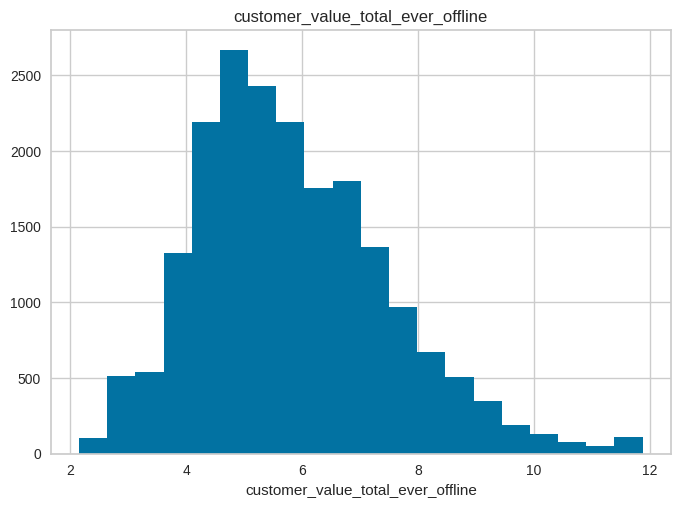

count   19945.000
mean        7.038
std         2.376
min         2.351
5%          4.000
10%         4.397
20%         5.013
30%         5.582
40%         6.037
50%         6.592
60%         7.192
70%         7.892
80%         8.840
90%        10.266
95%        11.590
99%        14.649
max        15.599
Name: customer_value_total_ever_online, dtype: float64


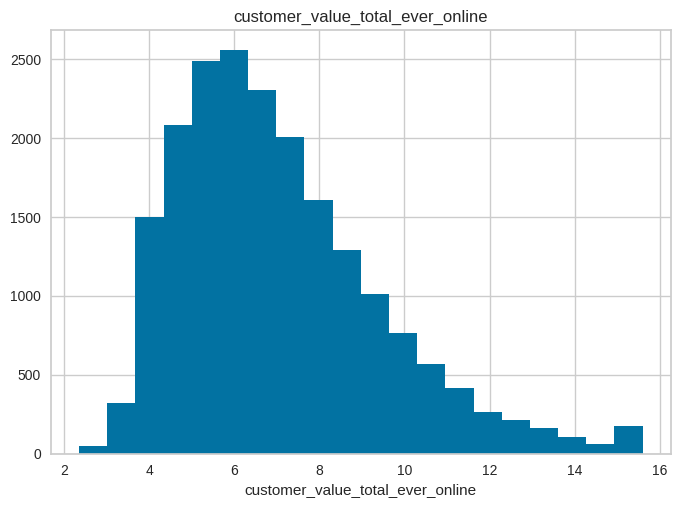

count   19945.000
mean        1.627
std         0.345
min         1.260
5%          1.260
10%         1.260
20%         1.260
30%         1.442
40%         1.442
50%         1.587
60%         1.587
70%         1.710
80%         1.913
90%         2.080
95%         2.289
99%         2.802
max         3.000
Name: customer_total_order, dtype: float64


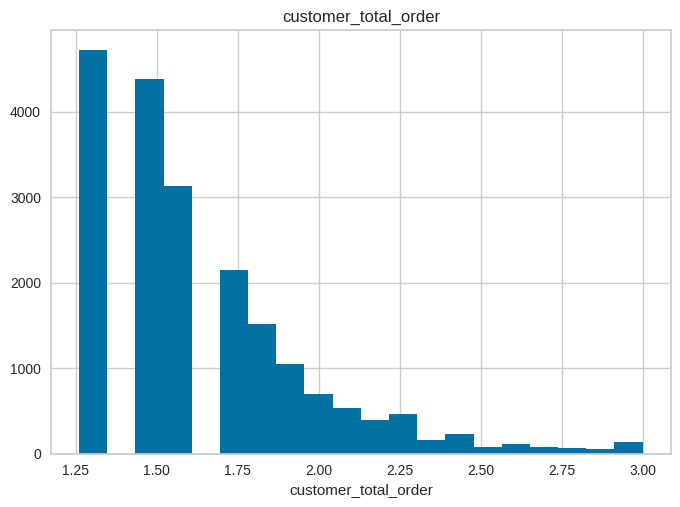

count   19945.000
mean        8.489
std         2.126
min         3.556
5%          5.599
10%         6.082
20%         6.711
30%         7.236
40%         7.696
50%         8.170
60%         8.708
70%         9.297
80%        10.066
90%        11.266
95%        12.433
99%        15.335
max        16.560
Name: customer_value_total, dtype: float64


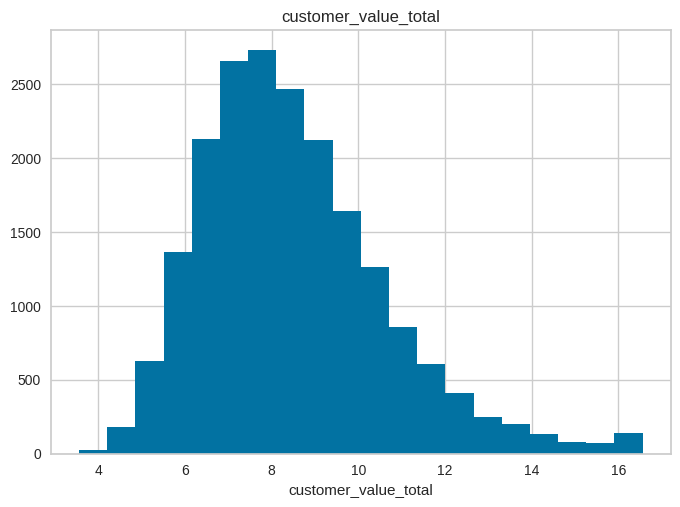

count   19945.000
mean        4.694
std         1.505
min         1.260
5%          2.080
10%         2.520
20%         3.208
30%         3.826
40%         4.362
50%         4.806
60%         5.254
70%         5.708
80%         6.145
90%         6.753
95%         6.945
99%         7.114
max         7.160
Name: recency, dtype: float64


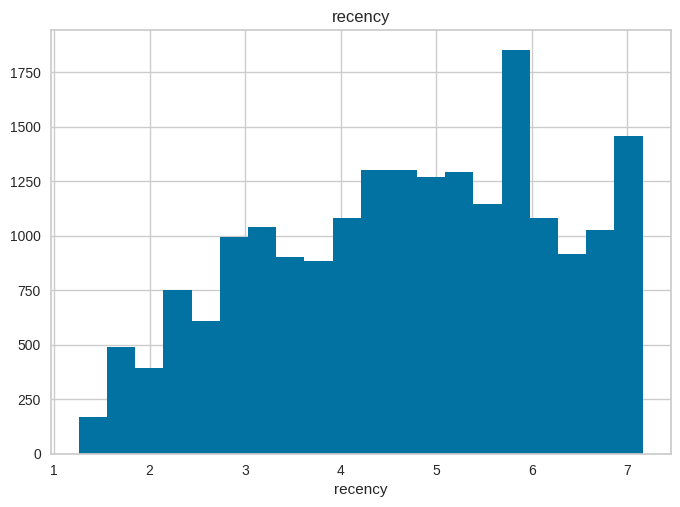

count   19945.000
mean        8.915
std         1.836
min         1.710
5%          5.936
10%         6.966
20%         7.819
30%         8.188
40%         8.434
50%         8.667
60%         9.004
70%         9.337
80%         9.889
90%        11.558
95%        12.753
99%        13.759
max        14.518
Name: tenure, dtype: float64


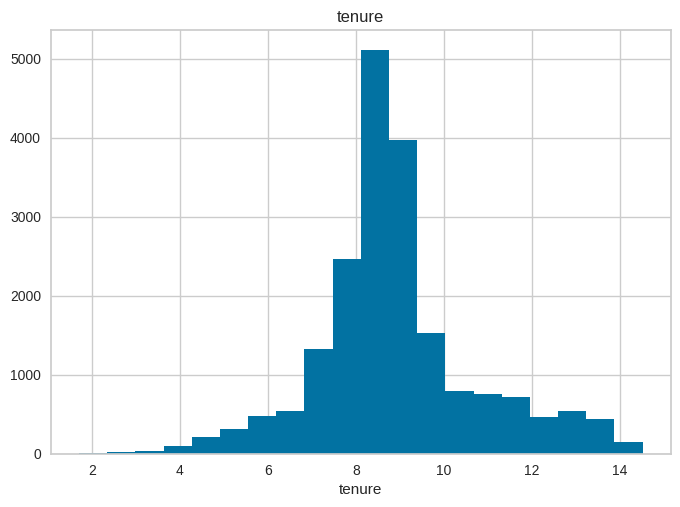

count   19945.000
mean        5.222
std         0.769
min         2.823
5%          4.091
10%         4.310
20%         4.592
30%         4.794
40%         4.977
50%         5.152
60%         5.343
70%         5.546
80%         5.810
90%         6.205
95%         6.586
99%         7.397
max         8.487
Name: avg_order_value, dtype: float64


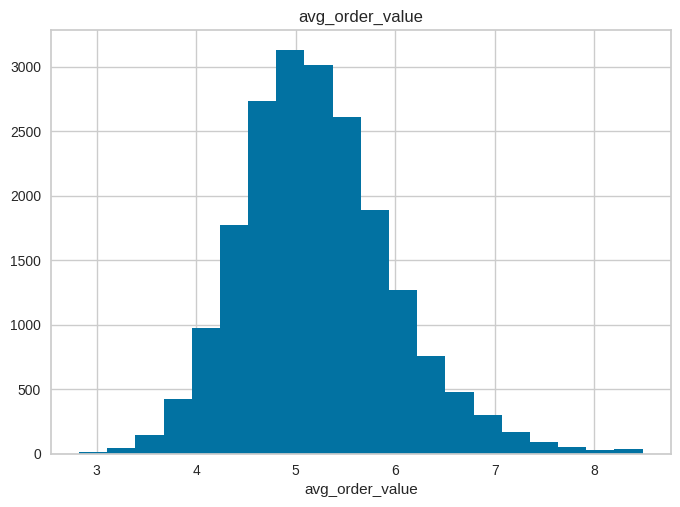

In [141]:
for col in model_df:
    num_summary(model_df , col , True)

# 🤖 7. Modeling

In [142]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(model_df)

# Eğer DataFrame olarak görmek istersen:
df_scaled = pd.DataFrame(df_scaled, columns=model_df.columns)

df_scaled.head()


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,customer_total_order,customer_value_total,recency,tenure,avg_order_value
0,0.659,-0.776,-0.385,0.944,0.240,0.614,-0.087,-1.598,0.658
1,3.407,0.327,-0.243,2.208,3.281,1.947,0.016,1.480,-0.839
2,0.290,0.327,-0.050,0.127,0.240,-0.058,0.674,-0.388,-0.429
3,-0.834,-0.776,-1.453,-1.134,-1.065,-1.660,0.290,-1.987,-1.673
4,-0.834,-0.776,-1.294,-0.677,-1.065,-1.197,-0.186,-0.095,-0.656


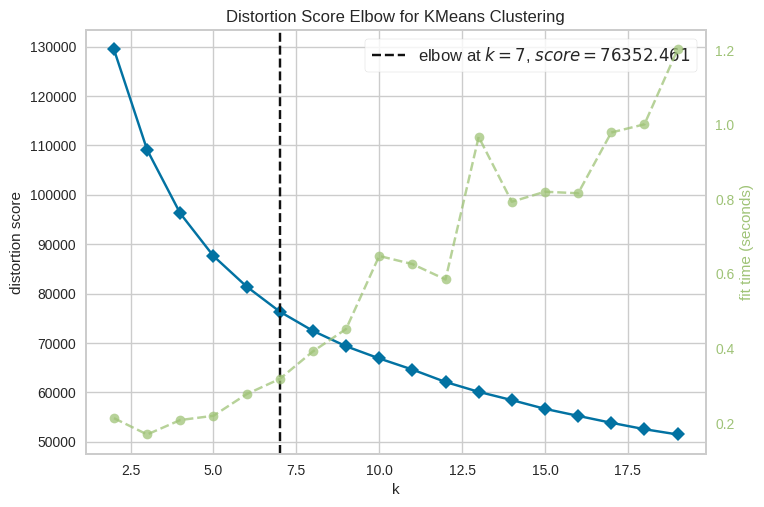

7

In [143]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_scaled)
elbow.show()

elbow.elbow_value_

In [144]:
k_means = KMeans(n_clusters=elbow.elbow_value_, random_state=42)
k_means.fit(df_scaled)


print(k_means.cluster_centers_)
print(k_means.inertia_)
print(k_means.labels_)

cust_segments = k_means.labels_

[[-0.50956465 -0.51754766 -0.49989209 -0.52096629 -0.68353388 -0.70715513
  -0.99452336 -0.80948802 -0.24509752]
 [ 2.53236387  0.16524695  0.08184164  2.34842589  2.38851785  2.21959961
  -0.37930166  1.02465074  0.26804823]
 [-0.49356324  0.84111712  0.54855121 -0.60109474 -0.04071831 -0.24280472
   0.27830234  0.20499999 -0.33915146]
 [-0.4305433  -0.47059662  0.33315937  0.17139498 -0.60026821  0.24304281
   0.13254557 -0.47843548  1.4628375 ]
 [ 0.16575885  1.91633323  1.75271362  0.23925769  0.97039255  1.00332429
  -0.32887352  0.22186307  0.28504273]
 [-0.55425301 -0.6047917  -0.78102329 -0.72836524 -0.75700972 -0.99875708
   0.76373129 -0.01963173 -0.71621881]
 [ 0.97223997 -0.37490854 -0.42880869  0.82865524  0.66668685  0.52813021
  -0.12390911  0.44270467 -0.03468763]]
76352.92786493005
[6 1 2 ... 0 4 5]


In [145]:
final_df = df.copy()
final_df["segment"] = cust_segments


In [146]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online              order_num_total_ever_offline              \
                               mean   min    max                         mean   min   max   
segment                                                                                     
0                             1.539 1.000  5.000                        1.238 1.000 4.000   
1                            13.188 5.000 23.500                        2.054 1.000 8.500   
2                             1.569 1.000  6.000                        2.718 1.000 8.500   
3                             1.675 1.000  6.000                        1.279 1.000 3.000   
4                             3.069 1.000 13.000                        4.557 2.000 8.500   
5                             1.466 1.000  6.000                        1.156 1.000 3.000   
6                             5.198 2.000 14.000                        1.378 1.000 4.000   

        customer_value_total_ever_offline                  customer_value_total_ever_online  \
                                     mean     min      max                             mean   
segment                                                                                       
0                                 138.846  11.980  650.850                          218.190   
1                                 267.047  12.990 1675.570                         2113.986   
2                                 322.046  63.850  979.900                          197.897   
3                                 294.677  14.990 1675.570                          473.321   
4                                 713.438 164.960 1675.570                          516.459   
5                                 102.645  10.000  355.730                          168.874   
6                                 154.014  10.490  699.470                          769.225   

                         recency            tenure                   
            min      max    mean min  max     mean  min   max count  
segment                                                              
0        14.000  796.870  41.634   2  185  466.357    5  2234  3032  
1       649.400 3795.830  96.930   2  365 1380.974   50  3060  1270  
2        14.990  625.780 157.583   2  367  869.738  138  3044  3390  
3        12.990 3795.830 145.551   2  367  568.054   12  2767  2834  
4        39.990 3476.810 100.740   2  365  875.337   55  2968  1894  
5        14.000  595.880 213.022   8  367  764.535   98  3037  4208  
6       161.760 2226.290 120.151   2  367 1019.242   52  3054  3317

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method="ward"))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
c_average = linkage(df_scaled, method='average')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dendrogram(
    c_average,
    truncate_mode="lastp",
    p=10,
    show_contracted=True,
    leaf_font_size=10
)
plt.axhline(y=5.5, color='r', linestyle='--')
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(
    n_clusters=5,
    affinity="euclidean",
    linkage="ward"
)

final_df["hier_cluster"] = hc.fit_predict(df_scaled)
final_df.head()


In [ ]:
final_df["hier_cluster"].value_counts()

In [ ]:
final_df.groupby("hier_cluster").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})